In [ ]:
# por si es necesario xgboost
#!pip install xgboost

In [245]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import average_precision_score, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
from xgboost.sklearn import XGBClassifier

# Carga de Datos

In [216]:
data = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [217]:
data = data.rename(columns={'default payment next month': 'target'})

In [218]:
data = data[[col for col in data.columns if col != 'ID']]

# Train Test Split

In [219]:
train, test = train_test_split(data, train_size=0.6, random_state=42)

In [220]:
internal_test, external_test = train_test_split(test, train_size=0.6, random_state=42)

In [269]:
external_test.to_json('datos_prueba.json', orient='records')

# EDA rápido (tasas naturales por grupo y pairplots)

## Tasas naturales

In [225]:
train['target'].value_counts()

0    14007
1     3993
Name: target, dtype: int64

In [226]:
train['target'].mean()

0.22183333333333333

#### Tasa natural de 22.2%

## Bivariante

In [221]:
NUMBER_COLS = [col for col in data.columns if ('BILL' in col or 'AGE' in col or 'BAL' in col or 'PAY_AMT' in col) and col != 'MARRIAGE']
CATEGORICAL_COLS = [col for col in data.columns if col not in NUMBER_COLS and col != 'target']

#### Categoricas

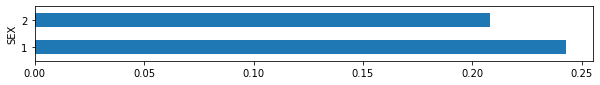

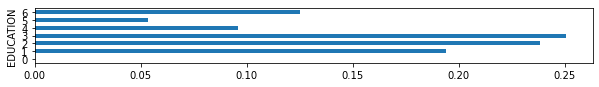

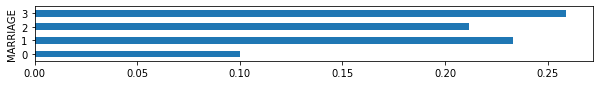

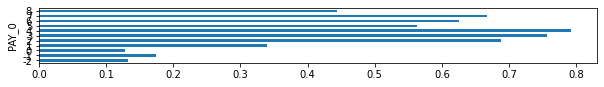

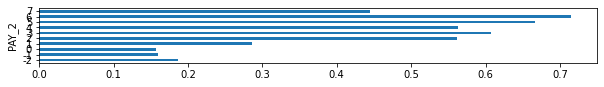

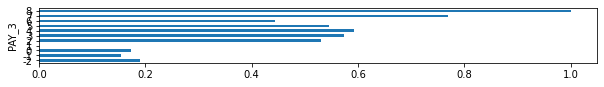

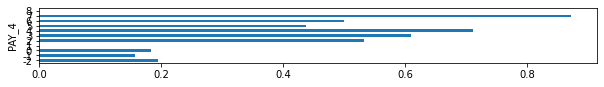

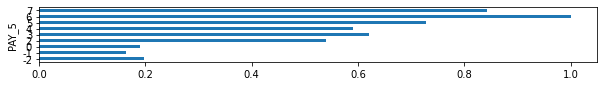

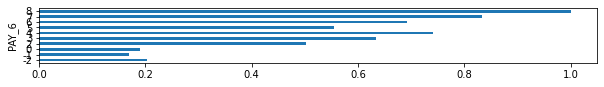

In [265]:
for col in CATEGORICAL_COLS:
    train.groupby(col)['target'].mean().round(5).plot.barh(figsize=(10,1))
    plt.show()

#### Numericas

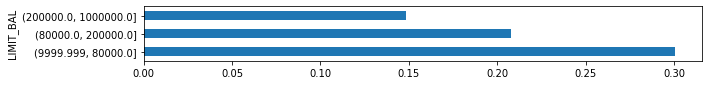

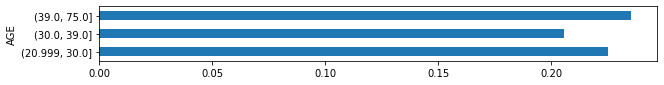

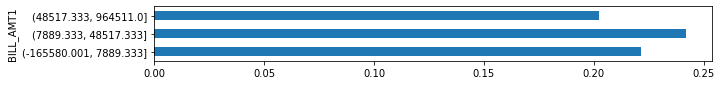

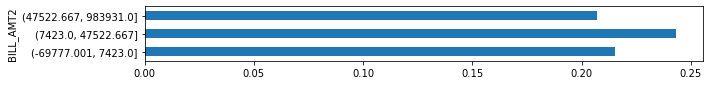

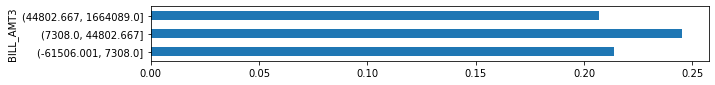

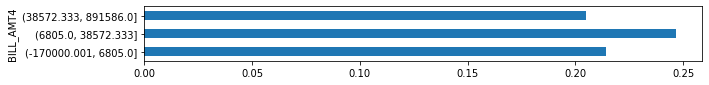

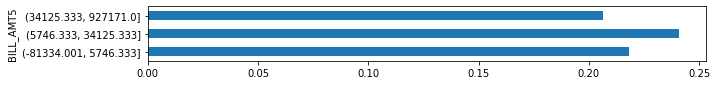

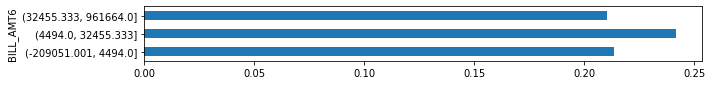

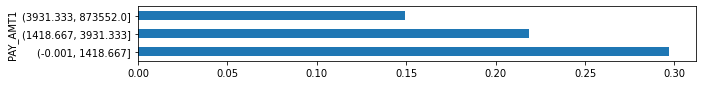

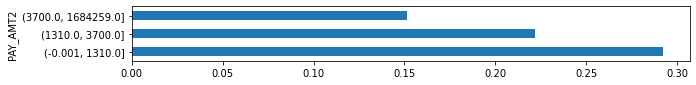

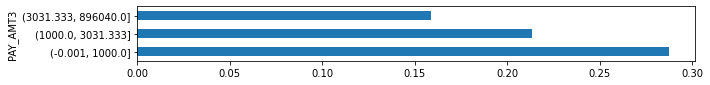

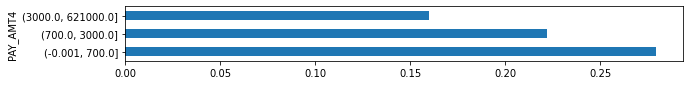

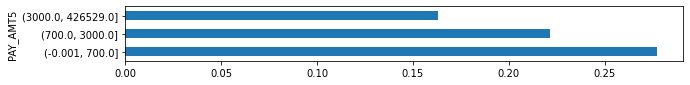

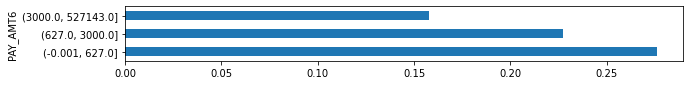

In [266]:
for col in NUMBER_COLS:
    train.groupby(pd.qcut(train[col], q=3))['target'].mean().round(5).plot.barh(figsize=(10,1))
    plt.show()

# Modelamiento

In [249]:
X_train = train[[col for col in data.columns if col != 'target']]
X_test = internal_test[[col for col in data.columns if col != 'target']]
y_train = train['target']
y_test = internal_test['target']

In [250]:
xgb_model = XGBClassifier(n_estimators=20, max_depth=3).fit(X_train, y_train)

[13:39:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Importancias

<AxesSubplot:>

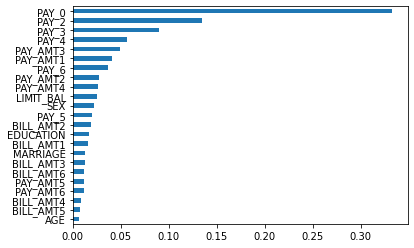

In [251]:
pd.Series(dict(list(zip(list(data.columns), xgb_model.feature_importances_)))).sort_values().plot.barh()

### Obtención de resultados

In [252]:
y_train_prob_predictions = xgb_model.predict_proba(X_train)[:, 1]
y_test_prob_predictions = xgb_model.predict_proba(X_test)[:, 1]

# Revisión de rendimiento

## Calidad de ordenamiento

### Entrenamiento

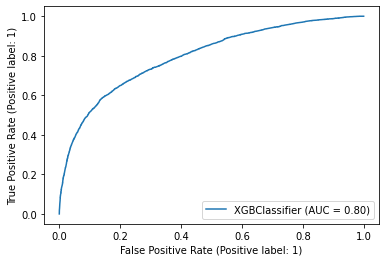

In [253]:
plot_roc_curve(xgb_model, X_train, y_train)

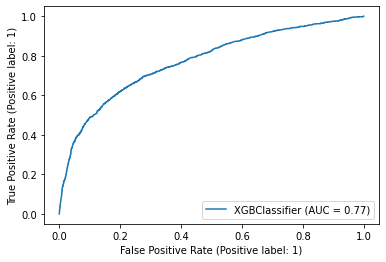

In [254]:
plot_roc_curve(xgb_model, X_test, y_test)

### AUC

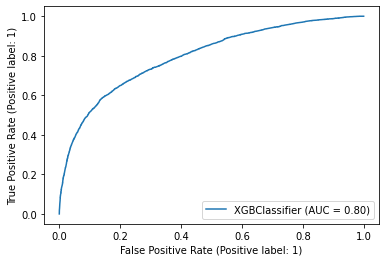

In [255]:
plot_roc_curve(xgb_model, X_train, y_train)

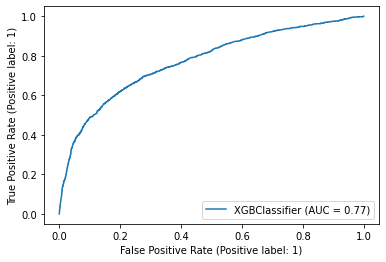

In [256]:
plot_roc_curve(xgb_model, X_test, y_test)

#### Existe sobreajuste pero no es nada preocupante

## Calibración umbral de probabilidades

In [257]:
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob_predictions)
pr_curve_pd = pd.DataFrame({'precision': precision, 'recall': recall, 'thresholds': np.array([0] + list(thresholds))}).set_index('thresholds')

# Asumimos f1-score
pr_curve_pd['f1_score'] = 2*(pr_curve_pd['precision']*pr_curve_pd['recall'])/(pr_curve_pd['precision'] + pr_curve_pd['recall'])

<AxesSubplot:xlabel='thresholds'>

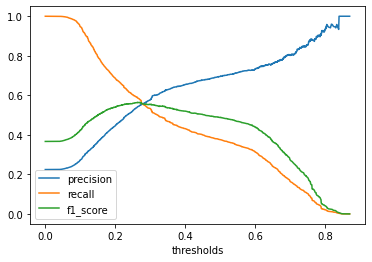

In [258]:
pr_curve_pd.plot()

In [259]:
pr_curve_pd['f1_score'].sort_values()

thresholds
0.870291    0.000000
0.851399    0.000501
0.847705    0.001001
0.846739    0.001502
0.842847    0.003999
              ...   
0.264305    0.563899
0.268979    0.563928
0.269117    0.563959
0.269059    0.563997
0.269134    0.564028
Name: f1_score, Length: 9813, dtype: float64

### Mayor f1-score en torno a 0.25

## Calculo rendimientos clasificación dura

In [260]:
print(classification_report(y_train, y_train_prob_predictions > 0.25))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     14007
           1       0.52      0.60      0.56      3993

    accuracy                           0.79     18000
   macro avg       0.70      0.72      0.71     18000
weighted avg       0.80      0.79      0.79     18000



In [261]:
print(classification_report(y_test, y_test_prob_predictions > 0.25))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      5662
           1       0.48      0.59      0.53      1538

    accuracy                           0.78      7200
   macro avg       0.68      0.71      0.69      7200
weighted avg       0.80      0.78      0.78      7200



Existen alguno cambios en el precision para la clase 0, y el recall de la clase 1 entre train y test, pero es bastante leve, por lo que se entrena el modelo con lo aprendido.

# Exportacion

In [262]:
joblib.dump(xgb_model, 'modelo_default_final.pkl')

['modelo_default_final.pkl']